# Identify Eye vergence in eye-tracking signal
Our signal is binocular, eye vergence is estimated from the fixation disparity between the two eye positions on the screen.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2 
import pandas as pd
import re
import time
import statistics
import math
import sklearn
from sklearn import metrics
from scipy import stats
from tqdm.auto import tqdm
import sklearn
from sklearn.cluster import KMeans
import colorcet as cc
import matplotlib.patches as mpatches
from scipy.stats import linregress
import pingouin as pg


C:\Users\anais\AppData\Roaming\Python\Python37\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Set path where the eye-tracking files (.asc), which have been reparsed are
set_WD = os.getcwd() # get current work directory
wd_input= set_WD + "\\data\\raw_data\\eye_tracker\\reparsed_data"

# Import file with quality of memories (will be use to select only autobiographical memories)
quality_file = pd.read_csv(set_WD+ r"\data\processed_data\T1_quality.csv")

# file with questions where there is a VD visual disengagement = gaze aversion (will be use because we analyse vergence only on trials where there is no gaze aversion)
VD_file_access = pd.read_csv(set_WD+ r"\data\processed_data\data_T1_access.csv")
VD_file_elaboration = pd.read_csv(set_WD+r"\data\processed_data\data_T1_visu.csv")

# files with percentage of gaze aversion for each subject during access and elaboration
perc_aversion_access = pd.read_csv(set_WD+r"\data\processed_data\files for statitical analyses\perc_aversion_subj_access.csv")
perc_aversion_elaboration = pd.read_csv(set_WD+r"\data\processed_data\files for statitical analyses\perc_aversion_subj_elaboration.csv")

# set path to directory to save figures
wd_output=set_WD+"\\data\\figures"
wd_output_file =set_WD+"\\data\\processed_data\\eye vergence"

In [3]:
# list of all the questions
list_of_all_questions = ['auto_eloges.wav', 'auto_match_sport.wav', 'auto_dormir_amis.wav', 'auto_mariage.wav', 'auto_karaoke.wav', 'auto_don_association.wav', \
                         'auto_livre.wav', 'auto_musique_amis.wav', 'auto_nouveaux_vetements.wav', 'auto_naissance.wav', 'auto_loterie.wav', 'auto_fete_peres.wav', \
                         'auto_deco_noel.wav', 'auto_apprendre_conduire.wav', 'auto_concert.wav', 'auto_carte_postale.wav', 'auto_cadeau.wav', 'auto_ballade_romantique.wav', \
                         'auto_coin_du_feu.wav', 'auto_animal_compagnie.wav', 'auto_conge.wav', 'auto_cadeau_noel.wav', 'auto_chanson_preferee.wav', 'auto_calin.wav', \
                         'auto_nouvel_an.wav', 'auto_photos_famille.wav', 'auto_perdu_ville.wav', 'auto_pic-nique.wav', 'auto_premier_baiser.wav', 'auto_film_canape.wav', \
                         'auto_premiere_fois_etranger.wav', 'auto_plat_prefere.wav', 'auto_gagner_jeu.wav', 'auto_permis_conduire.wav', 'auto_peint_mur.wav', 'auto_porte_bonheur.wav', \
                         'auto_plage.wav', 'auto_neige.wav', 'auto_retrouvailles.wav', 'auto_vin.wav', 'auto_professeur_prefere.wav', 'auto_ponce_meuble.wav', 'auto_trente-et-un.wav', \
                         'auto_paques.wav', 'auto_vacances.wav', 'auto_vue_magnifique.wav', 'auto_tente.wav', 'auto_saint-valentin.wav']

# list of all the participants with their anonymized code
sujets =['P01','P02','P03','P04','P05','P06', \
      'P07','P09','P10','P11','P12','P13', \
      'P14','P15','P16','P17','P18', \
      'P19', 'P20', 'P21', 'P22', 'P23', 'P24', \
       'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33'] 

idd_participant={'1':'P01','2':'P02','3':'P03','4':'P04','5':'P05', \
     '6':'P06','7':'P07','9':'P09','10':'P10','11':'P11', \
     '12':'P12','13':'P13','14':'P14','15':'P15','16':'P16', \
     '17':'P17','18':'P18', '19': 'P19', '20': 'P20', '21': 'P21', '22': 'P22', '23':'P23', '24':'P24', '25':'P25', '26':'P26', '27':'P27', \
     '28': 'P28', '29':'P29', '30':'P30', '31':'P31', '32':'P32', '33':'P33'}

In [4]:
# create palette of 32 colors to associate 1 color to 1 participant in figures and graphs
palette = sns.color_palette(cc.glasbey_bw, n_colors=32)
palette = np.array(palette)

### Functions to calculate distance between eyes and plot results

In [9]:
def calcul_distance_acces(x_left,y_left,x_right,y_right) :
    '''
    afjskldafjjlafsafjksa
    Args : 
        x_left  : 
        y_left  : 
        x_right : 
        y_right :
        
    '''
    distance_eyes=[]
    distance_eyes_hori = []
    distance_eyes_verti = []
    for i in range(len(x_left)) :   
        delta_x=float(x_right[i])-float(x_left[i])
        delta_y=y_right[i]-y_left[i]
        delta_x2=delta_x*delta_x
        delta_y2=delta_y*delta_y
        delta=delta_x2+delta_y2
        distance_eyes.append(np.sqrt(delta))  
        distance_eyes_hori.append(delta_x)
        distance_eyes_verti.append(delta_y)
    return distance_eyes, distance_eyes_hori, distance_eyes_verti

def plot_figure_timeseries(distance_eyes,indx_A,indx_Q, indx_V, condition) :
    ouput=wd_output+"\\verg"+ condition + sujet+"."+audio+".png"
    pos=[]
    for i in range(len(distance_eyes)):
        pos.append(i)  
    xaxis = np.arange(0, pos[-1]+1)
    yaxis = np.array(distance_eyes)    
    plt.figure(figsize=(7,2.5),dpi=70)
    plt.title(titre,fontsize=15)
    plt.scatter(xaxis, yaxis, s= 1,color='green', linewidths=0.5)
    positions = (0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000, 13000, 14000, 15000, 16000, 17000)
    labels = ('0','2000','4000','6000','8000','10000','12000','14000','16000','18000','20000','22000','24000', '26000', '28000', '30000', '32000', '34000')
    plt.xticks(positions, labels)
    plt.xticks(rotation=45)
    plt.xlim(0,17000)
    plt.ylim(-0,15)
    plt.xlabel('Temps (ms)',fontsize=12)
    plt.ylabel('Distance gauche/droit (px)',fontsize=12)
    plt.axvline(x=indx_A, color='pink', linewidth=1)
    plt.text(indx_A+40,20,'Access',rotation=90)
    plt.axvline(x=indx_Q, color='pink', linewidth=1)
    plt.text(indx_Q+40,18,'Question',rotation=90)
    plt.axvline(x=indx_V, color='pink', linewidth=1)
    plt.text(indx_V+40,25,'Elab',rotation=90)
    #plt.savefig(ouput)
    plt.show()
    
def plot_gaze_position(x_left, y_left, x_right, y_right, title, period):

    fig=plt.figure(figsize=(6,8.5),dpi=80)
    ax = fig.add_axes([0.07,0.38,0.85,0.4])
    ax.set_yticks([])
    ax.set_xticks([])
    plt.rcParams['axes.facecolor'] = 'black'
    plt.xlabel('x [0,1024]')
    plt.ylabel('y [768,0]')
    plt.title(title)
    plt.xlim(-10,1034)
    plt.ylim(-778,10)
    if period =='CF':
        sns.scatterplot(data_eyes_positions['X'][1:indx_Q],-1*data_eyes_positions['Y'][1:indx_Q],data=data_eyes_positions,hue='eye')
        sns.scatterplot(data_eyes_positions['X'][len(x_left):len(x_left)+indx_Q],-1*data_eyes_positions['Y'][len(x_left):len(x_left)+indx_Q],data=data_eyes_positions,hue='eye')
    if period =='Access':
        sns.scatterplot(data_eyes_positions['X'][indx_A:indx_V-1],-1*data_eyes_positions['Y'][indx_A:indx_V-1],data=data_eyes_positions,hue='eye')
        sns.scatterplot(data_eyes_positions['X'][indx_A+len(x_left):indx_V-1+len(x_left)],-1*data_eyes_positions['Y'][indx_A+len(x_left):indx_V-1+len(x_left)],data=data_eyes_positions,hue='eye')
    if period =='Visu':
        sns.scatterplot(data_eyes_positions['X'][indx_V:len(x_left)],-1*data_eyes_positions['Y'][indx_V:len(x_left)],data=data_eyes_positions,hue='eye')
        sns.scatterplot(data_eyes_positions['X'][indx_V+len(x_left):],-1*data_eyes_positions['Y'][indx_V+len(x_left):],data=data_eyes_positions,hue='eye')
    plt.legend(bbox_to_anchor = (1, 0.98),loc = 'upper left')
    #plt.savefig(wd_output+'//gaze_positions' + period + sujet + bloc +'.png',bbox_inches = "tight")
    plt.show()

    
def plot_difference_eyes(x_left, y_left, x_right, y_right, title, period):

    fig=plt.figure(figsize=(6,8.5),dpi=80)
    ax = fig.add_axes([0.07,0.38,0.85,0.4])
    ax.set_yticks([])
    ax.set_xticks([])
    plt.xlabel('x [0,1024]')
    plt.ylabel('y [768,0]')
    plt.title(title)
    plt.xlim(-10,1034)
    plt.ylim(-778,10)
    
    if period =='CF':
        xx = np.vstack([x_left[1:indx_Q],x_right[1:indx_Q]])
        yy = np.vstack([y_left[1:indx_Q],y_right[1:indx_Q]])  

    if period =='Access':
        xx = np.vstack([x_left[indx_A:indx_V-1],x_right[indx_A:indx_V-1]])
        yy = np.vstack([y_left[indx_A:indx_V-1],y_right[indx_A:indx_V-1]])
        
    if period =='Visu':
        xx = np.vstack([x_left[indx_V:],x_right[indx_V:]])
        yy = np.vstack([y_left[indx_V:],y_right[indx_V:]])
        
    plt.plot(xx,-1*yy, '-ok', mfc='C1', mec='C1')
    #plt.savefig(wd_output+'//gaze_differences' + period + sujet + bloc +'.png',bbox_inches = "tight")
    plt.show()

os.chdir(wd_input)
lst_files = os.listdir()
lst_files.sort()
lst = []
for asc_file in lst_files:
    if ".asc" in asc_file:
       lst.append(asc_file)
x_left=[]
y_left=[]
x_right=[]
y_right=[]

Method taken from : [Centroid of fixation and normalization with bounding circles of each eye](http://arxiv.org/abs/1901.06572)

In [10]:
def delete_bad_fixation(x_left, x_right, y_left, y_right, indx_SFIX_L, indx_SFIX_R, indx_EFIX_L, indx_EFIX_R, sujet, bloc):
    
    indx_SFIX_L_corrected = [] 
    indx_EFIX_L_corrected = [] 
    indx_SFIX_R_corrected = [] 
    indx_EFIX_R_corrected = [] 
    for i in range(len(indx_SFIX_L)):

        x_left_coord = x_left[indx_SFIX_L[i]:indx_EFIX_L[i]]
        y_left_coord = y_left[indx_SFIX_L[i]:indx_EFIX_L[i]]

        if x_left_coord.count(0) < 5 or y_left_coord.count(0) < 5:
            indx_SFIX_L_corrected.append(indx_SFIX_L[i])
            indx_EFIX_L_corrected.append(indx_EFIX_L[i])

    for i in range(len(indx_SFIX_R)):

        x_right_coord = x_right[indx_SFIX_R[i]:indx_EFIX_R[i]]
        y_right_coord = y_right[indx_SFIX_R[i]:indx_EFIX_R[i]]

        if x_right_coord.count(0) < 5 or y_right_coord.count(0) < 5:
            indx_SFIX_R_corrected.append(indx_SFIX_R[i])
            indx_EFIX_R_corrected.append(indx_EFIX_R[i])   
    
    counter = 0
    counter2 = 0
    same_start_SFIX_L = []
    same_start_EFIX_L = []
    same_start_SFIX_R = []
    same_start_EFIX_R = []

    there = 0

    for i in range(len(indx_SFIX_L_corrected)):

        if indx_SFIX_L_corrected[i] in indx_SFIX_R_corrected :
            same_start_SFIX_L.append(indx_SFIX_L_corrected[i])
            same_start_EFIX_L.append(indx_EFIX_L_corrected[i])

            find_same = indx_SFIX_R_corrected.index(indx_SFIX_L_corrected[i])
            
            same_start_SFIX_R.append(indx_SFIX_R_corrected[find_same])
            same_start_EFIX_R.append(indx_EFIX_R_corrected[find_same])

            there = indx_SFIX_L_corrected[i]
            counter = counter +1
        else:
            for j in range(indx_SFIX_L_corrected[i]-25,indx_SFIX_L_corrected[i]+25) :
                if j in indx_SFIX_R_corrected:
                    same_start_SFIX_L.append(indx_SFIX_L_corrected[i])
                    same_start_EFIX_L.append(indx_EFIX_L_corrected[i])

                    find_around = indx_SFIX_R_corrected.index(j)
                    same_start_SFIX_R.append(indx_SFIX_R_corrected[find_around])
                    same_start_EFIX_R.append(indx_EFIX_R_corrected[find_around])
                    counter2 = counter2 + 1

    return same_start_SFIX_L, same_start_EFIX_L, same_start_SFIX_R, same_start_EFIX_R

In [11]:
# Function to extract data for each fixation separetely
def extract_fixation(x_left, x_right, y_left, y_right, indx_SFIX_L, indx_EFIX_L, indx_SFIX_R, indx_EFIX_R, sujet, bloc):
    '''
    
    '''
    fixation_number = []
    centroid_x_left = []
    centroid_y_left = []
    centroid_x_right = []
    centroid_y_right = []
    start_time_fixation_L = []
    end_time_fixation_L = []
    start_time_fixation_R = []
    end_time_fixation_R = []
    max_bounding_circles_radius_left = []
    max_bounding_circles_radius_right = []
   
    
    stimulus = [] 
                        
    for i in range(len(indx_SFIX_L)):
                
        bounding_circles_radius_left = []
        bounding_circles_radius_right = []
       

        fixation_number.append(i+1)

        x_left_coord = x_left[indx_SFIX_L[i]+3:indx_EFIX_L[i]-3]
        y_left_coord = y_left[indx_SFIX_L[i]+3:indx_EFIX_L[i]-3]
        x_right_coord = x_right[indx_SFIX_R[i]+3:indx_EFIX_R[i]-3]
        y_right_coord = y_right[indx_SFIX_R[i]+3:indx_EFIX_R[i]-3]
        
        df_fixation_coord_left = pd.DataFrame({'x_left_coord':x_left_coord, 'y_left_coord':y_left_coord})
        df_fixation_coord_right = pd.DataFrame({'x_right_coord':x_right_coord, 'y_right_coord':y_right_coord})

        centroid_x_left.append(statistics.mean(x_left_coord))
        centroid_y_left.append(statistics.mean(y_left_coord))
        centroid_x_right.append(statistics.mean(x_right_coord))
        centroid_y_right.append(statistics.mean(y_right_coord))
        

        start_time_fixation_L.append(indx_SFIX_L[i])
        end_time_fixation_L.append(indx_EFIX_L[i])  
        start_time_fixation_R.append(indx_SFIX_R[i])
        end_time_fixation_R.append(indx_EFIX_R[i])  


        for k in range(len(df_fixation_coord_left['x_left_coord'])):
            bounding_circles_radius_left.append(math.sqrt((df_fixation_coord_left['x_left_coord'][k]-statistics.mean(x_left_coord))**2+(df_fixation_coord_left['y_left_coord'][k]-statistics.mean(y_left_coord))**2))
        max_bounding_circles_radius_left.append(max(bounding_circles_radius_left))

        for k in range(len(df_fixation_coord_right['x_right_coord'])):
            bounding_circles_radius_right.append(math.sqrt((df_fixation_coord_right['x_right_coord'][k]-statistics.mean(x_right_coord))**2+(df_fixation_coord_right['y_right_coord'][k]-statistics.mean(y_right_coord))**2))
        max_bounding_circles_radius_right.append(max(bounding_circles_radius_right))


        if 0 <= indx_SFIX_L[i] < indx_Q:
            stimulus.append("CF")
        elif indx_Q <= indx_SFIX_L[i] < indx_A:
            stimulus.append("Question")
        elif indx_A <= indx_SFIX_L[i] < indx_V:
            stimulus.append("Access")
        elif indx_V <= indx_SFIX_L[i] < len(x_left):
            stimulus.append("Visu")
            
        
    df_fixations = pd.DataFrame({'fixation_number':fixation_number, 'stimulus': stimulus, 'start_time_fix_left': start_time_fixation_L, 'end_time_fix_left': end_time_fixation_L, 'start_time_fix_right': start_time_fixation_R, 'end_time_fix_right': end_time_fixation_R,"centroid_x_left": centroid_x_left, 'centroid_y_left': centroid_y_left, \
                                'centroid_x_right':centroid_x_right, 'centroid_y_right': centroid_y_right, 'max_bounding_circles_radius_left':max_bounding_circles_radius_left, 'max_bounding_circles_radius_right':max_bounding_circles_radius_right})
    

    df_good_fixations = df_fixations.drop(df_fixations[(df_fixations['max_bounding_circles_radius_left'] ==0)].index)
    df_good_fixations = df_good_fixations.drop(df_good_fixations[(df_good_fixations['max_bounding_circles_radius_right'] ==0)].index)
    
    df_good_fixations['distance_between_eyes'] = ''
    df_good_fixations['normalized_distance_between_eyes'] = '' # divided by the sum of circles radii
    for i in range(len(df_good_fixations['fixation_number'])):
        df_good_fixations['distance_between_eyes'][i] = math.sqrt((df_good_fixations['centroid_x_left'][i]-df_good_fixations['centroid_x_right'][i])**2 + (df_good_fixations['centroid_y_left'][i]-df_good_fixations['centroid_y_right'][i])**2)
        df_good_fixations['normalized_distance_between_eyes'][i] = df_good_fixations['distance_between_eyes'][i]/(df_good_fixations['max_bounding_circles_radius_left'][i]+df_good_fixations['max_bounding_circles_radius_right'][i])
    
    df_good_fixations['duration_fixation_left'] = ''
    df_good_fixations['duration_fixation_right'] = '' # to calculate duration of fixations
    for i in range(len(df_good_fixations['fixation_number'])):
        df_good_fixations['duration_fixation_left'][i] = (df_good_fixations['end_time_fix_left'][i] - df_good_fixations['start_time_fix_left'][i])*2 #*2 to transoform in milliseconds because the time is in timesteps with frequency sampling ay 500 Hz
        df_good_fixations['duration_fixation_right'][i] = (df_good_fixations['end_time_fix_right'][i] - df_good_fixations['start_time_fix_right'][i])*2
        
        
    # ECRAN
    # 33.7x27 cm et de résolution 1024x768px

    df_good_fixations['hor_distance_pixels'] = ''
    df_good_fixations['ver_distance_pixels'] = ''
    df_good_fixations['hor_distance_mm'] = ''
    df_good_fixations['ver_distance_mm'] = ''
    df_good_fixations['distance_between_eyes_mm'] = ''
    df_good_fixations['normalized_distance_between_eyes_mm'] = ''
    

    for i in range(len(df_good_fixations)):
        df_good_fixations['hor_distance_pixels'][i]=df_good_fixations['centroid_x_right'][i] - df_good_fixations['centroid_x_left'][i]
        df_good_fixations['ver_distance_pixels'][i]=df_good_fixations['centroid_y_right'][i] - df_good_fixations['centroid_y_left'][i]
        df_good_fixations['hor_distance_mm'][i]=df_good_fixations['hor_distance_pixels'][i]/1024*337
        df_good_fixations['ver_distance_mm'][i]=df_good_fixations['ver_distance_pixels'][i]/768*270

        df_good_fixations['distance_between_eyes_mm'][i] = math.sqrt(df_good_fixations['hor_distance_mm'][i]**2 + df_good_fixations['ver_distance_mm'][i]**2)
        math.sqrt((df_fixation_coord_right['x_right_coord'][k]-statistics.mean(x_right_coord))**2+(df_fixation_coord_right['y_right_coord'][k]-statistics.mean(y_right_coord))**2)
        df_good_fixations['normalized_distance_between_eyes_mm'][i] = df_good_fixations['distance_between_eyes_mm'][i]/(df_good_fixations['max_bounding_circles_radius_left'][i]/1024*300+df_good_fixations['max_bounding_circles_radius_right'][i]/1024*300)
  
    return df_good_fixations

In [12]:
def plot_centroids_fixations(df_good_fixations, sujet, bloc, title, period):
    
    fig=plt.figure(figsize=(6,8.5),dpi=80)
    ax = fig.add_axes([0.07,0.38,0.85,0.4])
    ax.set_yticks([])
    ax.set_xticks([])
    plt.xlabel('x [0,1024]')
    plt.ylabel('y [768,0]')
    plt.title(title)
    plt.xlim(-10,1034)
    plt.ylim(-778,10)
    sns.scatterplot(df_good_fixations['centroid_x_left'],-1*df_good_fixations['centroid_y_left'],data=df_good_fixations, size=df_good_fixations['max_bounding_circles_radius_left'], alpha = 0.5)
    sns.scatterplot(df_good_fixations['centroid_x_right'],-1*df_good_fixations['centroid_y_right'],data=df_good_fixations, size=df_good_fixations['max_bounding_circles_radius_right'], alpha = 0.5)
    
    plt.legend(bbox_to_anchor = (1, 0.98),loc = 'upper left')
    plt.show()


In [13]:
kept_trials_for_vergence = 0 # counter to count how many trials are kept and have valid data for vergence calcultation

# variables to save in recapitulative file at the end
list_sujets = []
list_blocs = []
list_questions = []
list_stimulus = []
list_distance_between_eyes = []
list_normalized_distance_between_eyes = []
list_Z_score_distance_between_eyes = []
list_Z_score_normalized_distance_between_eyes = []
list_fixation_duration = []
list_centroid_x_left = []
list_centroid_y_left = []
list_centroid_x_right = []
list_centroid_y_right = []



for filename in tqdm(lst) :    
    fichier = csv.reader(open(filename),delimiter='\t')
    sujet=filename[4:-15] 
    bloc=filename[-14:-13]
    ind_acces=0    
    
    #select the questions where the answer corresponds to an autobiographical memory
    select_sujet = quality_file[quality_file['sujet_num'] == float(sujet)]
    select_bloc = select_sujet[select_sujet['Bloc'] == float(bloc)]
    
    #select the question only if there is no visual disengagement during the trial
    #access
    select_VD_access_sujet = VD_file_access[VD_file_access['sujet_num'] == float(sujet)]
    select_VD_access_bloc = select_VD_access_sujet[select_VD_access_sujet['Bloc'] == float(bloc)]
    where_no_VD = select_VD_access_bloc.index[select_VD_access_bloc['VD_here'] == 0].tolist() 
    #elaboration
    select_VD_elaboration_sujet = VD_file_elaboration[VD_file_elaboration['sujet_num'] == float(sujet)]
    select_VD_elaboration_bloc = select_VD_elaboration_sujet[select_VD_elaboration_sujet['Bloc'] == float(bloc)]
    where_no_VD_elaboration = select_VD_elaboration_bloc.index[select_VD_elaboration_bloc['nb_VD'] == 0].tolist()
    
       
    if float(sujet) > 1: # because sujet 1 was not recorded in bipolar mode
        
        for row in fichier: 
            roww=','.join(row)

            if "FIX_DOT" in roww :  
                ind_acces=1 #to dtermine if we are in the access phase
                ind_fix=0
                fix=0
                pattern='auto'
                audio=roww[roww.index(pattern):]
                titre=audio[5:-4]+' ('+sujet+'.'+bloc+')'
                x_left=[]
                y_left=[]
                x_right=[]
                y_right=[]
                indx_SFIX_L = []
                indx_SFIX_R = []
                indx_EFIX_L = []
                indx_EFIX_R = []
                data_eyes_positions = {}
                ind_fix=0
                nb_fix=0
                
                                
                fixation_x_coord_left = {'fixation': [], 'fixation_coord': []}
                fixation_y_coord_left = {'fixation': [], 'fixation_coord': []}
                fixation_x_coord_right = {'fixation': [], 'fixation_coord': []}
                fixation_y_coord_right = {'fixation': [], 'fixation_coord': []}
                
            
            if ind_acces==1 :
                ind_go=1
                if "S" in row[0] or "E" in row[0]:  #detect when it is an event row (FIX, SACC, loggers, ...)
                    ind_go=0
                    if 'FIX' not in row[0]:
                        ind_fix=0
                if ind_go==1:
                    #When there are coordinates
                    if "S" not in row[0] and "E" not in row[0] and " ." not in row[1] and " ." not in row[4]: # make sure we have data for both eyes
                        x_coord=float(row[1])
                        y_coord=float(row[2])
                        if x_coord>=1 and x_coord<=1022 and y_coord>=1 and y_coord<=766: #quand dans l'ecran
                            ind_in=1
                            ind_out=0
                        if x_coord<1 or x_coord>1022 or y_coord<1 or y_coord>766: #quand hors de l'ecran
                            ind_out=1
                            ind_in=0
                    #When there are no coordinate (signal loss)
                    if " ." in row[1] or " ." in row[2] or " ." in row[4] or " ." in row[5]:
                        ind_out=1
                        ind_in=0
                    #if no transition
                    if ind_in==1 and ind_fix==1:
                        x_left.append(float(row[1]))
                        y_left.append(float(row[2]))
                        x_right.append(float(row[4]))
                        y_right.append(float(row[5]))                   
                    if ind_in!=1 or ind_fix!=1:
                        x_left.append(0)
                        y_left.append(0)
                        x_right.append(0)
                        y_right.append(0)
                    if ind_fix==1 and ind_in==1:
                        nb_fix=nb_fix+1

                #count saccades and fixations
                
                if "SFIX" in row[0]:
                    ind_fix=1
                    if "SFIX L" in row[0]:
                        indx_SFIX_L.append(len(x_left)+1)
                    if "SFIX R" in row[0]:
                        indx_SFIX_R.append(len(x_left)+1)

                if 'EFIX' in row[0] :
                    ind_fix=0
                    if "EFIX L" in row[0]:
                        indx_EFIX_L.append(len(x_left))
                    if "EFIX R" in row[0]:
                        indx_EFIX_R.append(len(x_left))

                        
            if "ACCES" in roww:
                indx_A = len(x_left)

            if "QUESTION" in roww:
                indx_Q = len(x_left)

            if "VISU" in roww :
                indx_V = len(x_left)

                     
            if "DEBRIEFING_AUDIO" in roww:
                ind_acces=0
#               
                # make sure we have signal for both eyes
                if len(indx_SFIX_L) > 0 and len(indx_SFIX_R) > 0 and len(indx_EFIX_L) > 0 and len(indx_EFIX_R) > 0:
                    # delete if a fixation started before the trial and ends during the trial                    
                    if indx_SFIX_L[0] > indx_EFIX_L[0]:
                        del indx_EFIX_L[0]
                    if indx_SFIX_R[0] > indx_EFIX_R[0]:
                        del indx_EFIX_R[0]
                        
                    
                if len(indx_SFIX_L) > 0 and len(indx_SFIX_R) > 0 and len(indx_EFIX_L) > 0 and len(indx_EFIX_R) > 0:
                    # delete if a fixation starts during the trial but ends after the end of the trial 
                    if indx_SFIX_L[-1] > indx_EFIX_L[-1]:
                        del indx_SFIX_L[-1]
                    if indx_SFIX_R[-1] > indx_EFIX_R[-1]:
                        del indx_SFIX_R[-1]


                    assert len(indx_SFIX_L) == len(indx_EFIX_L)
                    assert len(indx_SFIX_R) == len(indx_EFIX_R)
                    #********************************************


                    #select the question only if no visual disengagement during the trial
                    questions_no_VD_in_access = []
                    for index in where_no_VD:
                        if select_VD_access_bloc['VD_here'][index] == 0:
                            questions_no_VD_in_access.append(select_VD_access_bloc['audio'][index])

                    questions_no_VD_in_elaboration = []
                    for index in where_no_VD_elaboration:
                        if select_VD_elaboration_bloc['nb_VD'][index] == 0:
                            questions_no_VD_in_elaboration.append(select_VD_elaboration_bloc['audio'][index])

                    if len(select_bloc[select_bloc['audio'].str.match(audio)].index.values) > 0:
                    # select question only if autobiographical memory
                        index_of_question = select_bloc[select_bloc['audio'].str.match(audio)].index.values
                        index_of_question = index_of_question[0]
                        selected_memory = select_bloc['Etape_1'][index_of_question]
                    if selected_memory == 'A' and audio in questions_no_VD_in_access and audio in questions_no_VD_in_elaboration:

                        print('sujet =', sujet, ', bloc =', bloc, ', audio =', audio)

                        #Calculate average of positions x and y for each eye for each fixation
                        same_start_SFIX_L, same_start_EFIX_L, same_start_SFIX_R, same_start_EFIX_R = delete_bad_fixation(x_left, x_right, y_left, y_right, indx_SFIX_L, indx_SFIX_R, indx_EFIX_L, indx_EFIX_R, sujet, bloc)
                        df_good_fixations = extract_fixation(x_left, x_right, y_left, y_right, same_start_SFIX_L, same_start_EFIX_L, same_start_SFIX_R, same_start_EFIX_R, sujet, bloc)
                        df_good_fixations['normalized_distance_between_eyes'] = df_good_fixations['normalized_distance_between_eyes'].astype(np.number)
                        df_good_fixations['distance_between_eyes'] = df_good_fixations['distance_between_eyes'].astype(np.number)

                        # PLOT DISTANCE BETWEEN CENTROIDS
                        title_CF = 'Fixation cross: Right and left eyes positions \n' + audio
                        title_Access = 'Access: Right and left eyes positions \n' + audio
                        title_Visu = 'Elaboration: Right and left eyes positions \n' + audio

                        # plot_centroids_fixations(df_good_fixations[df_good_fixations['stimulus'] == 'CF'], sujet, bloc, title_CF, 'CF')
                        # plot_centroids_fixations(df_good_fixations[df_good_fixations['stimulus'] == 'Access'], sujet, bloc, title_Access, 'Access')
                        # plot_centroids_fixations(df_good_fixations[df_good_fixations['stimulus'] == 'Visu'], sujet, bloc, title_Visu, 'Visu')

                        # For each trial, calculate average distance between left and right eyes during fixations
                        if 'CF' in list(df_good_fixations['stimulus']):

                            mean_df_good_fixations =df_good_fixations.groupby(['stimulus'], as_index = False).mean()
                            std_df_good_fixations = df_good_fixations.groupby(['stimulus']).std()
                            std_df_good_fixations = std_df_good_fixations.reset_index()
                            meanCF_index = list(mean_df_good_fixations['stimulus']).index("CF")
                            stdCF_index = list(std_df_good_fixations['stimulus']).index("CF")

                            df_good_fixations['Z_score_distance_between_eyes'] =''
                            df_good_fixations['Z_score_normalized_distance_between_eyes'] =''
                            for i in range(len(df_good_fixations)):
                                if np.isnan(std_df_good_fixations['distance_between_eyes'][stdCF_index]) ==False:
                                    df_good_fixations['Z_score_distance_between_eyes'][i] = (df_good_fixations['distance_between_eyes'][i]-mean_df_good_fixations['distance_between_eyes'][meanCF_index])/std_df_good_fixations['distance_between_eyes'][stdCF_index]
                                    df_good_fixations['Z_score_normalized_distance_between_eyes'][i] = (df_good_fixations['normalized_distance_between_eyes'][i]-mean_df_good_fixations['normalized_distance_between_eyes'][meanCF_index])/std_df_good_fixations['normalized_distance_between_eyes'][stdCF_index]
                                elif np.isnan(std_df_good_fixations['distance_between_eyes'][stdCF_index]) ==True:
                                    df_good_fixations['Z_score_distance_between_eyes'][i] = (df_good_fixations['distance_between_eyes'][i]-mean_df_good_fixations['distance_between_eyes'][meanCF_index])
                                    df_good_fixations['Z_score_normalized_distance_between_eyes'][i] = (df_good_fixations['normalized_distance_between_eyes'][i]-mean_df_good_fixations['normalized_distance_between_eyes'][meanCF_index])

                            for i in range(len(df_good_fixations['fixation_number'])):

                                list_sujets.append(sujet)
                                list_blocs.append(bloc)
                                list_questions.append(audio)
                                list_fixation_duration.append(df_good_fixations['duration_fixation_left'][i])
                                list_centroid_x_left.append(df_good_fixations['centroid_x_left'][i])
                                list_centroid_y_left.append(df_good_fixations['centroid_y_left'][i])
                                list_centroid_x_right.append(df_good_fixations['centroid_x_right'][i])
                                list_centroid_y_right.append(df_good_fixations['centroid_y_right'][i])
                                
                                list_stimulus.append(df_good_fixations['stimulus'][i])
                                list_distance_between_eyes.append(df_good_fixations['distance_between_eyes'][i])
                                list_normalized_distance_between_eyes.append(df_good_fixations['normalized_distance_between_eyes'][i])
                                list_Z_score_distance_between_eyes.append(df_good_fixations['Z_score_distance_between_eyes'][i])
                                list_Z_score_normalized_distance_between_eyes.append(df_good_fixations['Z_score_normalized_distance_between_eyes'][i])
                                
                            results_vergence = pd.DataFrame({'sujet':list_sujets, 'bloc':list_blocs, 'question':list_questions, 'stimulus': list_stimulus, 'fix_duration':list_fixation_duration, \
                                                            'centroid_x_left': list_centroid_x_left, 'centroid_y_left': list_centroid_y_left, \
                                                             'centroid_x_right': list_centroid_x_right, 'centroid_y_right': list_centroid_y_right, \
                                                             'distance_between_eyes':list_distance_between_eyes, \
                                                              'normalized_distance_between_eyes':list_normalized_distance_between_eyes, 'Z_score_distance_between_eyes':list_Z_score_distance_between_eyes, \
                                                            'Z_score_normalized_distance_between_eyes':list_Z_score_normalized_distance_between_eyes})
                                                             # create dataframe to save data about vergence

                            kept_trials_for_vergence = kept_trials_for_vergence +1 #counter to count the number of trials on which the vergence analysis is done         

                    elif selected_memory == 'NoA' or audio not in questions_no_VD_in_access or audio not in questions_no_VD_in_elaboration:
                        #print('to not select this question...')
                        continue


print('number of trials for vergence analysis =', kept_trials_for_vergence)

  0%|          | 0/128 [00:00<?, ?it/s]

sujet = 10 , bloc = 2 , audio = auto_vacances.wav


C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A valu

sujet = 10 , bloc = 2 , audio = auto_retrouvailles.wav
sujet = 11 , bloc = 1 , audio = auto_mariage.wav
sujet = 11 , bloc = 1 , audio = auto_musique_amis.wav
sujet = 11 , bloc = 1 , audio = auto_fete_peres.wav
sujet = 11 , bloc = 1 , audio = auto_naissance.wav
sujet = 11 , bloc = 2 , audio = auto_calin.wav
sujet = 11 , bloc = 2 , audio = auto_deco_noel.wav
sujet = 11 , bloc = 3 , audio = auto_tente.wav
sujet = 11 , bloc = 3 , audio = auto_neige.wav


C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sujet = 11 , bloc = 3 , audio = auto_retrouvailles.wav
sujet = 11 , bloc = 3 , audio = auto_trente-et-un.wav
sujet = 11 , bloc = 3 , audio = auto_plage.wav
sujet = 11 , bloc = 3 , audio = auto_paques.wav
sujet = 12 , bloc = 1 , audio = auto_trente-et-un.wav
sujet = 12 , bloc = 1 , audio = auto_plage.wav
sujet = 12 , bloc = 1 , audio = auto_paques.wav
sujet = 12 , bloc = 1 , audio = auto_neige.wav
sujet = 12 , bloc = 1 , audio = auto_tente.wav
sujet = 12 , bloc = 1 , audio = auto_ponce_meuble.wav
sujet = 12 , bloc = 1 , audio = auto_vacances.wav
sujet = 12 , bloc = 1 , audio = auto_professeur_prefere.wav
sujet = 12 , bloc = 1 , audio = auto_retrouvailles.wav
sujet = 12 , bloc = 1 , audio = auto_vin.wav
sujet = 12 , bloc = 1 , audio = auto_vue_magnifique.wav
sujet = 12 , bloc = 2 , audio = auto_conge.wav
sujet = 12 , bloc = 2 , audio = auto_concert.wav
sujet = 12 , bloc = 2 , audio = auto_carte_postale.wav
sujet = 12 , bloc = 2 , audio = auto_cadeau.wav
sujet = 12 , bloc = 2 , audio = au

In [14]:
results_vergence.to_csv(wd_output_file + "/distance_between_eyes.csv") # save data in .csv at this stage to avoid running the previous code again because it can last long

In [5]:
results_vergence = pd.read_csv(wd_output_file + "/distance_between_eyes.csv") # if already run the first part of the code and this file exist on your computuer, you can run directly from here

In [6]:
# To determine if there is a significant increased or decreased vergence during memory retrieval, we need a threshold
# We use the fixation cross (CF) as a baseline since participants fixate a cross on the screen, the distance between eyes should be small
# For all the fixations during the fixation cross, the average and standard deviation are calculated 
# then for fixation during access or elaboration in memory, the score Z of the distance between eyes can be calculated on the parameters from CF

Z_threshold = 1 # Z score cutoff to define significant difference

results_vergence['Z_distance != from threshold'] = ''
results_vergence['Z_normalized_distance != from threshold'] = ''

for i in range(len(results_vergence['sujet'])):
    if results_vergence['Z_score_distance_between_eyes'][i] > Z_threshold or results_vergence['Z_score_distance_between_eyes'][i] < -Z_threshold:
        results_vergence['Z_distance != from threshold'][i] = 'sig'
        
    else:
        results_vergence['Z_distance != from threshold'][i] = 'ns'
        
    if results_vergence['Z_score_normalized_distance_between_eyes'][i] > Z_threshold or results_vergence['Z_score_normalized_distance_between_eyes'][i] < -Z_threshold:
        results_vergence['Z_normalized_distance != from threshold'][i] = 'sig'
        
    else:
        results_vergence['Z_normalized_distance != from threshold'][i] = 'ns'

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_l

In [7]:
# Compare distance at every moment with CF by checking value of the Z_score
results_vergence['Convergence vs divergence'] = ''

for i in range(len(results_vergence['sujet'])):
    if results_vergence['Z_score_normalized_distance_between_eyes'][i] < 0:
        results_vergence['Convergence vs divergence'][i] = 'convergence'
    elif results_vergence['Z_score_normalized_distance_between_eyes'][i] > 0:
        results_vergence['Convergence vs divergence'][i] = 'divergence'
    elif results_vergence['Z_score_normalized_distance_between_eyes'][i] == 0:
        results_vergence['Convergence vs divergence'][i] = 'no change'


C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Given that a same trials can contain both fixations either divergence and convergence --> we consider that a trials shows a significant divergence or convergence if more than 70% of the fixations show one of those behaviour
# A trial will be "significant divergence" if the distance between the 2 eyes is higher than  1 Zscore or less than -1 Zscore for at least 70% of the fixations during the trials
# same criteria for "significant convergence"
# the role of this function is to identify which behaviour is the most representative of each trial for both access and elaboration phases separately

def plot_individual_behavior_vergence(period, criteria_for_sig):

    # keep only access period where there are significant changes in vergence 
    change_sig = criteria_for_sig
    change_sig = change_sig[change_sig['stimulus'] == period]

    _participant_ = []
    _question_ = []
    _behavior_ = [] # where 1 is divergence ; 0 is convergence; 2 is both convergence and divergence (none of them is there in more than 75% of the fixations); 999 missing data (deleted trial or visual disengagement)

    # identify the main behavior (convergence or divergence) for each question and each participant
    
    for ID in idd_participant:
        ID = int(ID)
        
        if ID in list(change_sig['sujet']):
            participant_access = change_sig[change_sig['sujet'] == ID]

            for question in list_of_all_questions:
                _participant_.append(ID)
                _question_.append(question)

                if question in list(participant_access['question']):
                    
                    participant_access_one_question = participant_access[participant_access['question'] == question]
                    percentage_divergence = 0
                    participant_access_one_question = participant_access_one_question.reset_index()
                    for val in range(len(participant_access_one_question['Convergence vs divergence'])):
                        if participant_access_one_question['Convergence vs divergence'][val] == 'divergence':
                            percentage_divergence = percentage_divergence + 1
                    percentage_divergence = (percentage_divergence/len(participant_access_one_question['Convergence vs divergence']))*100
                    if percentage_divergence >= 0.70:
                        _behavior_.append(1) # 1 for divergence
                    elif percentage_divergence <=0.30 :
                        _behavior_.append(0) # 0 for convergence
                    else :
                        _behavior_.append(2)

                elif question not in list(participant_access['question']):
                    _behavior_.append(999)

        elif ID not in list(change_sig['sujet']):
            for question in list_of_all_questions:
                _participant_.append(ID)
                _question_.append(question)
                _behavior_.append(999)

    individual_behavior = pd.DataFrame({'sujet':_participant_, 'question':_question_, 'behavior': _behavior_})

    return individual_behavior
    

In [9]:
individual_behavior_access = plot_individual_behavior_vergence('Access', results_vergence[results_vergence['Z_normalized_distance != from threshold'] == 'sig'])
individual_behavior_visu = plot_individual_behavior_vergence('Visu', results_vergence[results_vergence['Z_normalized_distance != from threshold'] == 'sig'])


In [10]:
# for %

div_access = individual_behavior_access[individual_behavior_access['behavior'] == 1]
conv_access = individual_behavior_access[individual_behavior_access['behavior'] == 0]
div_visu = individual_behavior_visu[individual_behavior_visu['behavior'] == 1]
conv_visu = individual_behavior_visu[individual_behavior_visu['behavior'] == 0]

suj = []
perc_div_access_suj = []
perc_conv_access_suj = []
perc_div_visu_suj = []
perc_conv_visu_suj = []

for ID in idd_participant:
    ID = int(ID)
    if ID in list(div_access['sujet']):
        suj.append(ID)
        df_suj_all = individual_behavior_access[individual_behavior_access['sujet'] == ID]
        df_suj_div = div_access[div_access['sujet'] == ID]
        perc_div_access_suj.append(len(df_suj_div)/len(df_suj_all)*100)
    elif ID not in list(div_access['sujet']):
        suj.append(ID)
        perc_div_access_suj.append(0)
    

suj = []

for ID in idd_participant:
    ID = int(ID)
    if ID in list(conv_access['sujet']):
        
        suj.append(ID)
        df_suj_all = individual_behavior_access[individual_behavior_access['sujet'] == ID]
        df_suj_conv = conv_access[conv_access['sujet'] == ID]
        perc_conv_access_suj.append(len(df_suj_conv)/len(df_suj_all)*100)
    elif ID not in list(conv_access['sujet']):
        
        suj.append(ID)
        perc_conv_access_suj.append(0)
        
suj = []

for ID in idd_participant:
    ID = int(ID)
    if ID in list(div_visu['sujet']):
        suj.append(ID)
        df_suj_all = individual_behavior_visu[individual_behavior_visu['sujet'] == ID]
        df_suj_div = div_visu[div_visu['sujet'] == ID]
        perc_div_visu_suj.append(len(df_suj_div)/len(df_suj_all)*100)
    elif ID not in list(div_visu['sujet']):
        suj.append(ID)
        perc_div_visu_suj.append(0)
        
suj = []

for ID in idd_participant:
    ID = int(ID)
    if ID in list(conv_visu['sujet']):
        
        suj.append(ID)
        df_suj_all = individual_behavior_visu[individual_behavior_visu['sujet'] == ID]
        df_suj_conv = conv_visu[conv_visu['sujet'] == ID]
        perc_conv_visu_suj.append(len(df_suj_conv)/len(df_suj_all)*100)
    elif ID not in list(conv_visu['sujet']):
        
        suj.append(ID)
        perc_conv_visu_suj.append(0)

ddf_recap = pd.DataFrame({'sujet': suj, 'per_trials_access_div': perc_div_access_suj, 'per_trials_access_conv': perc_conv_access_suj, 'per_trials_visu_div': perc_div_visu_suj, 'per_trials_visu_conv': perc_conv_visu_suj})
ddf_recap

,sujet,per_trials_access_div,per_trials_access_conv,per_trials_visu_div,per_trials_visu_conv
0,1,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000
2,3,16.666667,2.083333,31.250000,16.666667
3,4,18.750000,2.083333,37.500000,2.083333
4,5,2.083333,0.000000,0.000000,0.000000
5,6,4.166667,2.083333,31.250000,4.166667
6,7,6.250000,2.083333,8.333333,0.000000
7,9,41.666667,4.166667,43.750000,4.166667
8,10,2.083333,0.000000,0.000000,2.083333
9,11,14.583333,4.166667,16.666667,4.166667


# Plot histograms frequency of vergence change

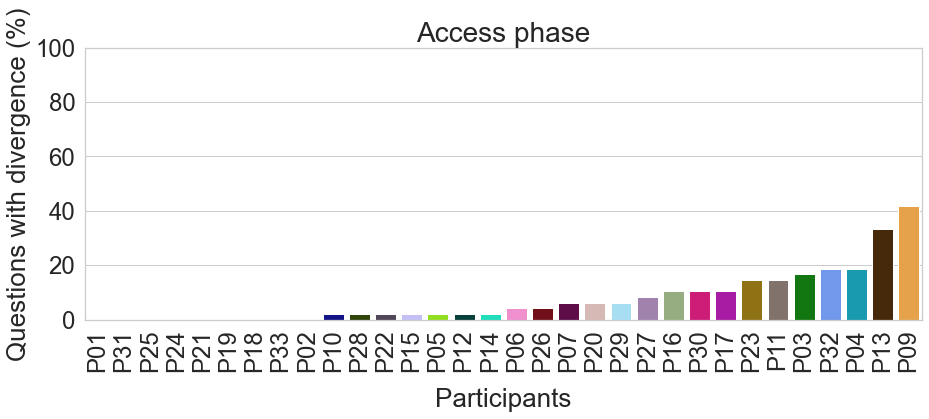

In [11]:
# Histrogram percentage of divergence during access phase for each participant

perc_div_access_sub = np.array(ddf_recap['per_trials_access_div'])
list_sub = np.array(ddf_recap['sujet'])
inds = perc_div_access_sub.argsort()

sorted_list_sub = list_sub[inds]  
anonymised_participants = []
for code in sorted_list_sub:
    if float(code) < 10:
        anonym_code = 'P0' + str(code)
        anonymised_participants.append(anonym_code)
    if float(code) >= 10:
        anonym_code = 'P' + str(code)
        anonymised_participants.append(anonym_code)
perc_div_access_sub.sort()
    
list_color_hist = []

for i, s in enumerate(anonymised_participants):
    s_numerique = int(s[1:])
        
    if s_numerique < 8:
        list_color_hist.append(palette[s_numerique-1])
    if s_numerique > 8:
        list_color_hist.append(palette[s_numerique-2])
 
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure(None)
sns.set(rc={'figure.figsize':(20,5)})
sns.set_style("whitegrid")
sns.barplot(x=anonymised_participants,y=perc_div_access_sub, palette = list_color_hist)
plt.ylim(0,100)
plt.title('Access phase', fontsize = 28)  
plt.xticks(rotation=90, fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Participants", fontsize = 26, labelpad = 16)
plt.ylabel("Questions with divergence (%)", fontsize = 26) 
    
plt.savefig(wd_output+ '/hist_perc_divergence_sujet_ACCESS.png', transparent=True,bbox_inches = "tight")
plt.show()

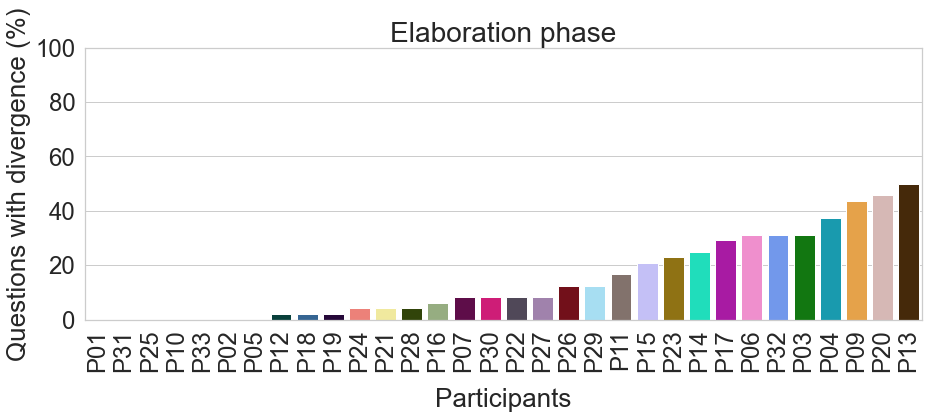

In [12]:
# Histrogram percentage of divergence during elaboration phase for each participant

perc_div_visu_sub = np.array(ddf_recap['per_trials_visu_div'])
list_sub = np.array(ddf_recap['sujet'])
inds = perc_div_visu_sub.argsort()

sorted_list_sub = list_sub[inds]  
anonymised_participants = []
for code in sorted_list_sub:
    if float(code) < 10:
        anonym_code = 'P0' + str(code)
        anonymised_participants.append(anonym_code)
    if float(code) >= 10:
        anonym_code = 'P' + str(code)
        anonymised_participants.append(anonym_code)
perc_div_visu_sub.sort()
    
list_color_hist = []

for i, s in enumerate(anonymised_participants):
    s_numerique = int(s[1:])
        
    if s_numerique < 8:
        list_color_hist.append(palette[s_numerique-1])
    if s_numerique > 8:
        list_color_hist.append(palette[s_numerique-2])

sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure(None)
sns.set(rc={'figure.figsize':(20,5)})
sns.set_style("whitegrid")
sns.barplot(x=anonymised_participants,y=perc_div_visu_sub, palette = list_color_hist)
plt.ylim(0,100)
plt.title('Elaboration phase', fontsize = 28)
        
plt.xticks(rotation=90, fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Participants", fontsize = 26, labelpad = 16)
plt.ylabel("Questions with divergence (%)", fontsize = 26)
  
plt.savefig(wd_output+ '/hist_perc_divergence_sujet_VISU.png', transparent=True,bbox_inches = "tight")
plt.show()

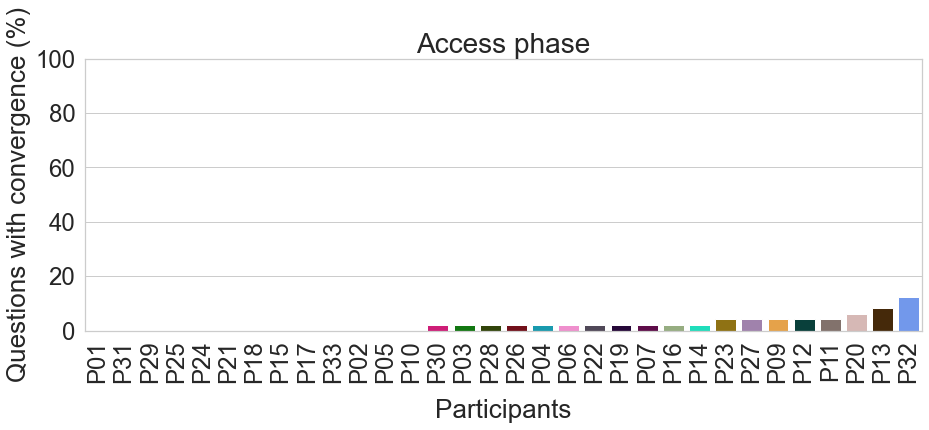

In [13]:
# Histrogram percentage of convergence during access phase for each participant

perc_conv_access_sub = np.array(ddf_recap['per_trials_access_conv'])
list_sub = np.array(ddf_recap['sujet'])
inds = perc_conv_access_sub.argsort()

sorted_list_sub = list_sub[inds]  
anonymised_participants = []
for code in sorted_list_sub:
    if float(code) < 10:
        anonym_code = 'P0' + str(code)
        anonymised_participants.append(anonym_code)
    if float(code) >= 10:
        anonym_code = 'P' + str(code)
        anonymised_participants.append(anonym_code)
perc_conv_access_sub.sort()
    
list_color_hist = []

for i, s in enumerate(anonymised_participants):
    s_numerique = int(s[1:])
        
    if s_numerique < 8:
        list_color_hist.append(palette[s_numerique-1])
    if s_numerique > 8:
        list_color_hist.append(palette[s_numerique-2])

sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure(None)
sns.set(rc={'figure.figsize':(20,5)})
sns.set_style("whitegrid")
sns.barplot(x=anonymised_participants,y=perc_conv_access_sub, palette = list_color_hist)
plt.ylim(0,100)
plt.title('Access phase', fontsize = 28)
    
plt.xticks(rotation=90, fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Participants", fontsize = 26, labelpad = 16)
plt.ylabel("Questions with convergence (%)", fontsize = 26)
    
plt.savefig(wd_output+ '/hist_perc_convergence_sujet_ACCESS.png', transparent=True,bbox_inches = "tight")
plt.show()

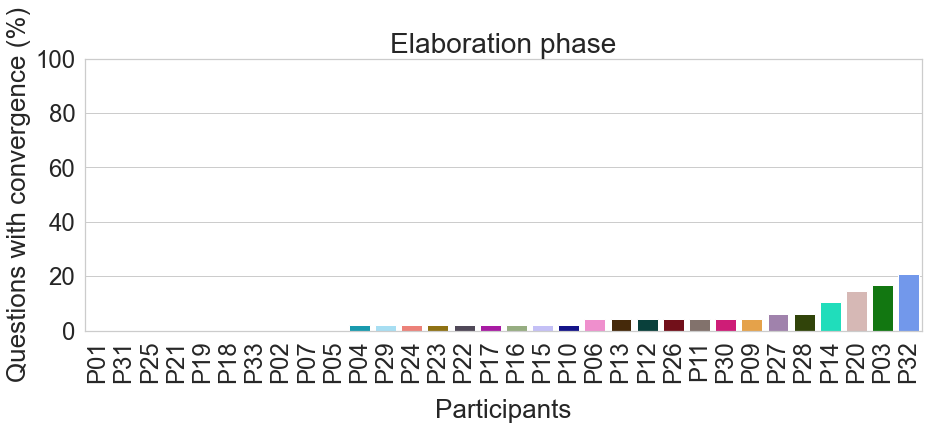

In [14]:
# Histrogram percentage of convergence during elaboration phase for each participant

perc_conv_visu_sub = np.array(ddf_recap['per_trials_visu_conv'])
list_sub = np.array(ddf_recap['sujet'])
inds = perc_conv_visu_sub.argsort()

sorted_list_sub = list_sub[inds]  
anonymised_participants = []
for code in sorted_list_sub:
    if float(code) < 10:
        anonym_code = 'P0' + str(code)
        anonymised_participants.append(anonym_code)
    if float(code) >= 10:
        anonym_code = 'P' + str(code)
        anonymised_participants.append(anonym_code)
perc_conv_visu_sub.sort()
    
list_color_hist = []

for i, s in enumerate(anonymised_participants):
    s_numerique = int(s[1:])
        
    if s_numerique < 8:
        list_color_hist.append(palette[s_numerique-1])
    if s_numerique > 8:
        list_color_hist.append(palette[s_numerique-2])


    
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure(None)
sns.set(rc={'figure.figsize':(20,5)})
sns.set_style("whitegrid")
sns.barplot(x=anonymised_participants,y=perc_conv_visu_sub, palette = list_color_hist)
plt.ylim(0,100)
plt.title('Elaboration phase', fontsize = 28) 
    
plt.xticks(rotation=90, fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Participants", fontsize = 26, labelpad = 16)
plt.ylabel("Questions with convergence (%)", fontsize = 26)   
    
plt.savefig(wd_output+ '/hist_perc_convergence_sujet_VISU.png', transparent=True,bbox_inches = "tight")
plt.show()

# Create dataframe for hierarchical clustering analysis (dendrogram from the paper)
The dataframe is created here and is used in R for the clustering analysis with NbClust

In [15]:
ddf_recap['VD_access'] = ''
ddf_recap['VD_visu'] = ''
ddf_recap['None_access'] = ''
ddf_recap['None_visu'] = ''

for i in range(len(perc_aversion_access)):
    suj_num = int(perc_aversion_access['sujet'][i][1:])
   
    for sub in range(len(ddf_recap)):
        if ddf_recap['sujet'][sub] == suj_num:
            ddf_recap['VD_access'][sub] = perc_aversion_access['perc_VD'][i]

for i in range(len(perc_aversion_elaboration)):
    suj_num = int(perc_aversion_elaboration['sujet'][i][1:])
   
    for sub in range(len(ddf_recap)):
        if ddf_recap['sujet'][sub] == suj_num:
            ddf_recap['VD_visu'][sub] = perc_aversion_elaboration['perc_VD'][i]
            
for i in range(len(ddf_recap)):
    ddf_recap['None_access'][i] = 100 - (ddf_recap['VD_access'][i]+ddf_recap['per_trials_access_div'][i]+ddf_recap['per_trials_access_conv'][i])
    ddf_recap['None_visu'][i] = 100 - (ddf_recap['VD_visu'][i]+ddf_recap['per_trials_visu_div'][i]+ddf_recap['per_trials_visu_conv'][i])
                 
ddf_recap.to_csv(set_WD+ r"\data\processed_data\files for clustering analyses\profile_vergence_aversion_dendrogram_clustering.csv")

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages

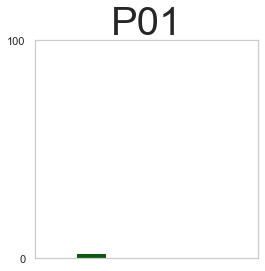

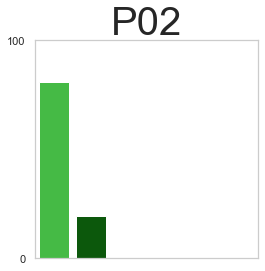

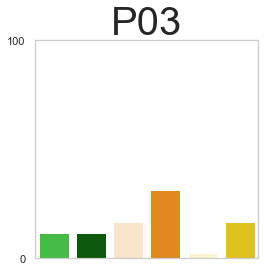

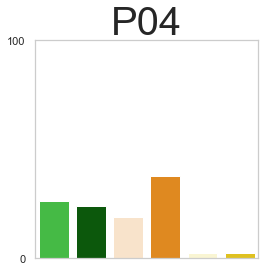

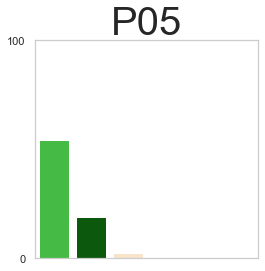

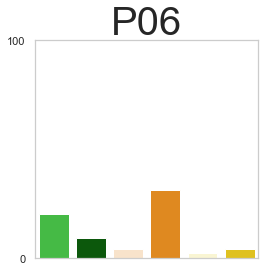

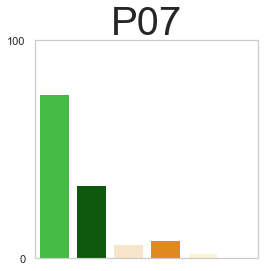

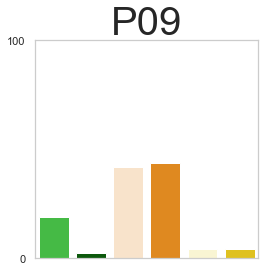

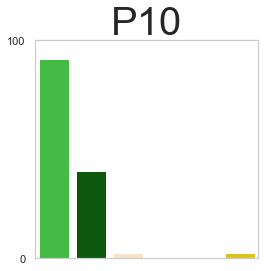

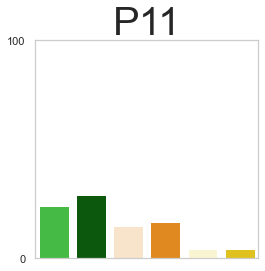

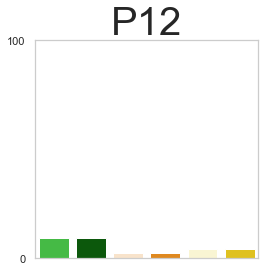

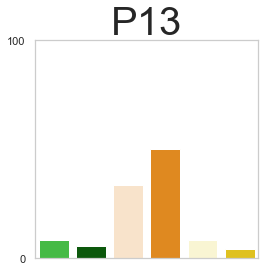

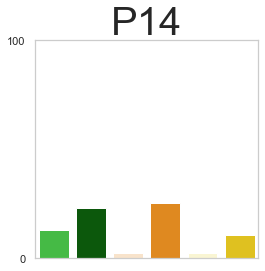

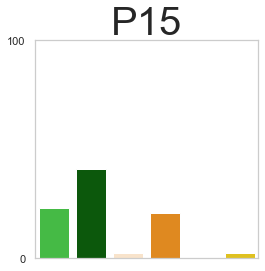

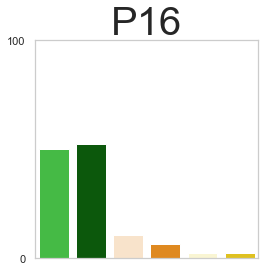

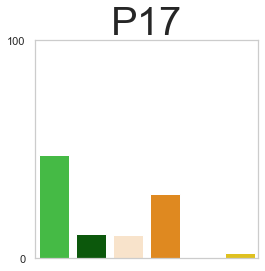

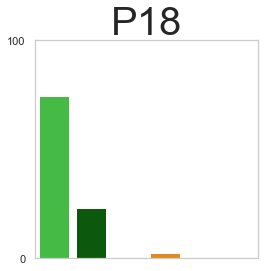

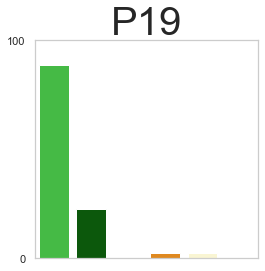

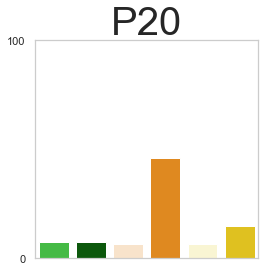

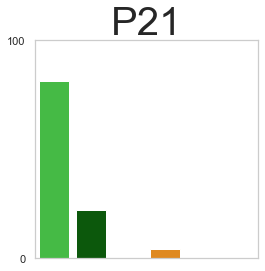

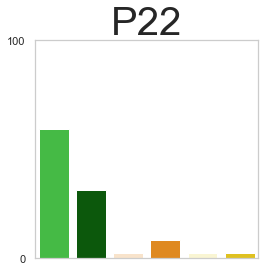

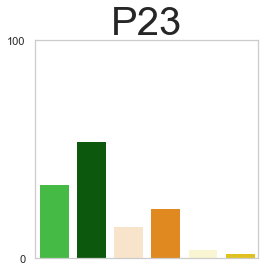

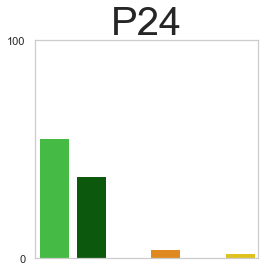

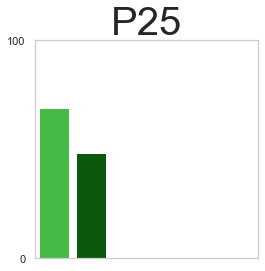

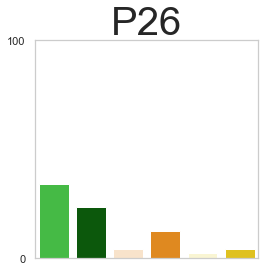

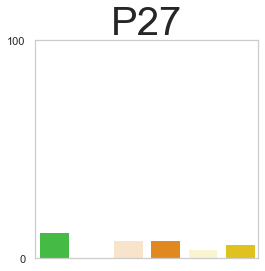

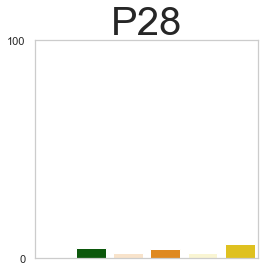

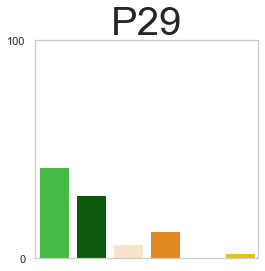

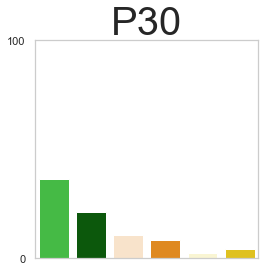

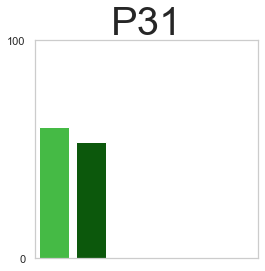

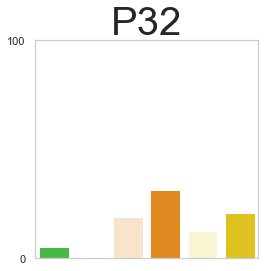

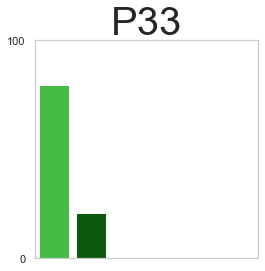

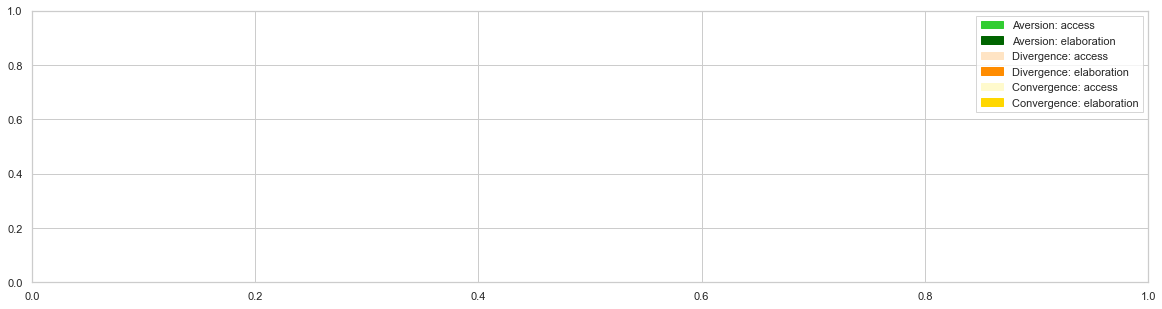

In [16]:
# Code to reproduce the individual plot bar in the dendrogram figure
# for every participant there is a bar plot with the percentage of trials with aversion, convergence, and divergence both during access and elaboration phase

for subj in list(ddf_recap['sujet']):

    ddf_recap_suj = ddf_recap[ddf_recap['sujet'] == subj]
    ddf_recap_sujet_crop = ddf_recap_suj[['VD_access','VD_visu','per_trials_access_div', 'per_trials_visu_div','per_trials_access_conv', 'per_trials_visu_conv']]
    ddf_recap_sujet_crop = ddf_recap_sujet_crop.reset_index(drop=True)
    x =ddf_recap_sujet_crop.columns
    y = []
    for col in x:
        y.append(ddf_recap_sujet_crop[col][0])
    plt.figure(figsize=(4, 4))
    sns.barplot(x=x,y=y, palette = ['limegreen', 'darkgreen', 'bisque', 'darkorange', 'lemonchiffon', 'gold'])
    if subj < 10:
        plt.title('P0'+str(subj), fontsize = 40)
    if subj >= 10:
        plt.title('P'+str(subj), fontsize = 40)
    plt.ylim(0,100)
    plt.xticks([], [])
    plt.yticks([0, 100])

    #plt.savefig(wd_output+ 'ocular_strategy_P'+str(subj)+'.png', transparent=False,bbox_inches = "tight")
    plt.show()
    plt.close()

# plot a legend for the bar plots colors
elements_legend_1 = mpatches.Patch(color='limegreen', label='Aversion: access')
elements_legend_2 = mpatches.Patch(color='darkgreen', label='Aversion: elaboration')
elements_legend_3 = mpatches.Patch(color='bisque', label='Divergence: access')
elements_legend_4 = mpatches.Patch(color='darkorange', label='Divergence: elaboration')
elements_legend_5 = mpatches.Patch(color='lemonchiffon', label='Convergence: access')
elements_legend_6 = mpatches.Patch(color='gold', label='Convergence: elaboration')

lgd = plt.legend(handles=[elements_legend_1, elements_legend_2, elements_legend_3, elements_legend_4, elements_legend_5, elements_legend_6], bbox_to_anchor=(1,1), loc='best', fancybox=False)
#plt.savefig(wd_output+ 'dendrogram_legend.png', transparent=False,bbox_inches = "tight")

# Correlation between gaze aversion and vergence change

C:\Users\anais\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


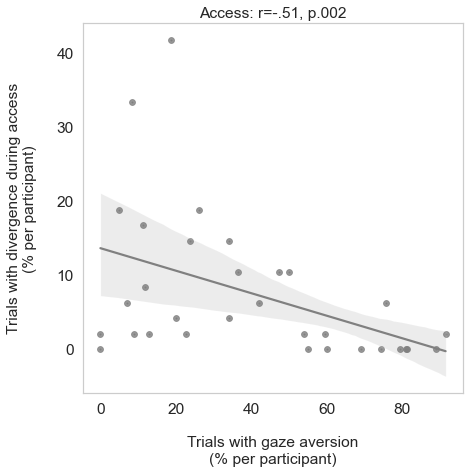

C:\Users\anais\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


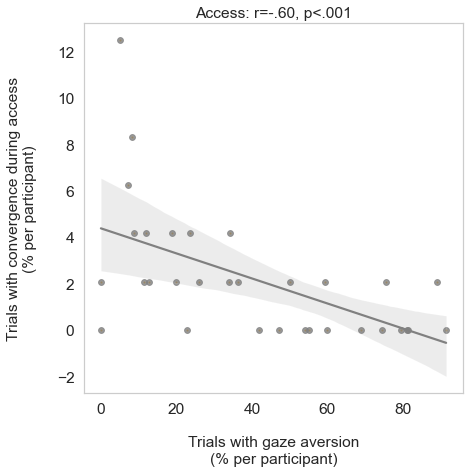

In [17]:
# Access
# Regression plot of the correlation between aversion and vergence change during access phase

# 1) Divergence
plt.figure(figsize=(7,7),dpi=70)
r = str(stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_div'])[0])[2:5] # calculate spearman correlation and p-value
p_value = stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_div'])[1]
if p_value < 0.001:
    p_value = "<.001"
else:
    p_value = str(stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_div'])[1])[1:5]
plt.title('Access: ' +'r=-'+r+', p' + p_value,fontsize=16)
sns.scatterplot(ddf_recap['VD_access'],ddf_recap['per_trials_access_div'], s= 5,color='gray', linewidths=0.5) 
df = pd.DataFrame({'VD_here':list(ddf_recap['VD_access']), 'divergence_here': list(ddf_recap['per_trials_access_div'])})
sns.regplot(x='VD_here', y='divergence_here', data=df, color = 'gray')
plt.xlabel('Trials with gaze aversion\n(% per participant)',fontsize=16, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.ylabel('Trials with divergence during access\n(% per participant)',fontsize=16, labelpad=20)
plt.savefig(wd_output + '/Access_correlation_Divergence_vs_Aversion.png',bbox_inches = "tight")
plt.show()

# 2) Convergence
plt.figure(figsize=(7,7),dpi=70)
r = str(stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_conv'])[0])[2:5]
p_value = stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_conv'])[1]
if p_value < 0.001:
    p_value = "<.001"
else:
    p_value = str(stats.spearmanr(ddf_recap['VD_access'], ddf_recap['per_trials_access_conv'])[1])[1:5]
plt.title('Access: ' +'r=-'+r+', p' + p_value,fontsize=16)
sns.scatterplot(ddf_recap['VD_access'],ddf_recap['per_trials_access_conv'], s= 5,color='orange', linewidths=0.5) 
df = pd.DataFrame({'VD_here':list(ddf_recap['VD_access']), 'convergence_here': list(ddf_recap['per_trials_access_conv'])})
sns.regplot(x='VD_here', y='convergence_here', data=df, color = 'gray')
plt.xlabel('Trials with gaze aversion\n(% per participant)',fontsize=16, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.ylabel('Trials with convergence during access\n(% per participant)',fontsize=16, labelpad=20)
plt.savefig(wd_output + '/Access_correlation_Convergence_vs_Aversion.png',bbox_inches = "tight")
plt.show()

C:\Users\anais\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


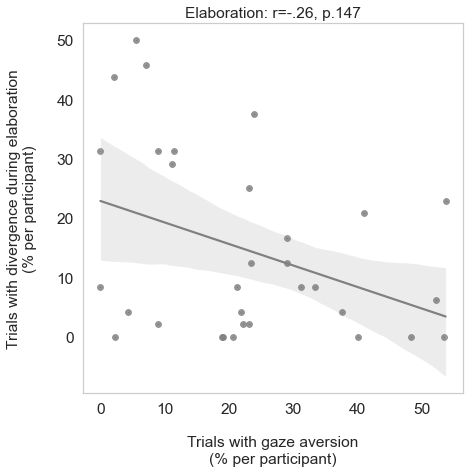

C:\Users\anais\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


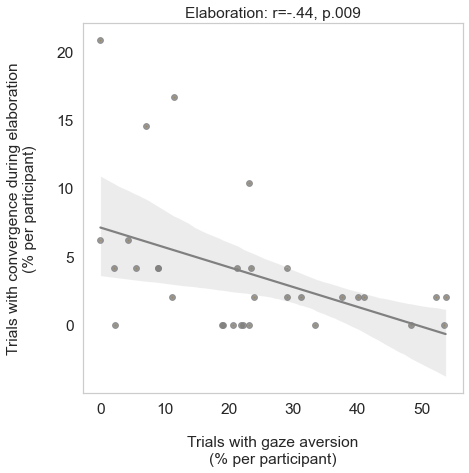

In [18]:
# Elaboration
# Regression plot of the correlation between aversion and vergence change during elaboration phase

# 1) Divergence
plt.figure(figsize=(7,7),dpi=70)
r = str(stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_div'])[0])[2:5] # calculate spearman correlation and p-value
p_value = stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_div'])[1]
if p_value < 0.001:
    p_value = "<.001"
else:
    p_value = str(stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_div'])[1])[1:5]
plt.title('Elaboration: ' +'r=-'+r+', p' + p_value,fontsize=16)
sns.scatterplot(ddf_recap['VD_visu'],ddf_recap['per_trials_visu_div'], s= 5,color='gray', linewidths=0.5) 
df = pd.DataFrame({'VD_here':list(ddf_recap['VD_visu']), 'divergence_here': list(ddf_recap['per_trials_visu_div'])})
sns.regplot(x='VD_here', y='divergence_here', data=df, color = 'gray')
plt.xlabel('Trials with gaze aversion\n(% per participant)',fontsize=16, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.ylabel('Trials with divergence during elaboration\n(% per participant)',fontsize=16, labelpad=20)
plt.savefig(wd_output + '/Elaboration_correlation_Divergence_vs_Aversion.png',bbox_inches = "tight")
plt.show()

# 2) Convergence
plt.figure(figsize=(7,7),dpi=70)
r = str(stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_conv'])[0])[2:5]
p_value = stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_conv'])[1]
if p_value < 0.001:
    p_value = "<.001"
else:
    p_value = str(stats.spearmanr(ddf_recap['VD_visu'], ddf_recap['per_trials_visu_conv'])[1])[1:5]
plt.title('Elaboration: ' +'r=-'+r+', p' + p_value,fontsize=16)
sns.scatterplot(ddf_recap['VD_visu'],ddf_recap['per_trials_visu_conv'], s= 5,color='orange', linewidths=0.5) 
df = pd.DataFrame({'VD_here':list(ddf_recap['VD_visu']), 'convergence_here': list(ddf_recap['per_trials_visu_conv'])})
sns.regplot(x='VD_here', y='convergence_here', data=df, color = 'gray')
plt.xlabel('Trials with gaze aversion\n(% per participant)',fontsize=16, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.ylabel('Trials with convergence during elaboration\n(% per participant)',fontsize=16, labelpad=20)
plt.savefig(wd_output + '/Elaboration_correlation_Convergence_vs_Aversion.png',bbox_inches = "tight")
plt.show()

# Link between change of vergence with effort and vividness during memory retrieval

Statistical tests (Friedman) and boxplots (supplementary)

In [19]:
# rename dataframes for vergence and gaze aversion (VD) during access and elaboration (just for more clarity)

vergence_file_access = individual_behavior_access 
vergence_file_visu = individual_behavior_visu

data_T1_access = VD_file_access 
data_T1_visu = VD_file_elaboration

In [20]:
# This code will combine info of the vergence in the dataframe of the gaze aversion

# add columns of interest to data_T1 and create new dataframe (combined_df)
combined_df_access = data_T1_access
combined_df_access['sig_vergence'] = '' # 1 = divergence et 0 = convergence

# add columns of interest to data_T1 and create new dataframe (combined_df)
combined_df_visu = data_T1_visu
combined_df_visu['sig_vergence'] = '' # 1 = divergence et 0 = convergence

# for access
for i in range(len(vergence_file_access['sujet'])):
    for k in range(len(combined_df_access['sujet_num'])):
        if vergence_file_access['sujet'][i] == combined_df_access['sujet_num'][k] and vergence_file_access['question'][i] == combined_df_access['audio'][k] :
            combined_df_access['sig_vergence'][k] = vergence_file_access['behavior'][i]
# for elaboration
for i in range(len(vergence_file_visu['sujet'])):
    for k in range(len(combined_df_visu['sujet_num'])):
        if vergence_file_visu['sujet'][i] == combined_df_visu['sujet_num'][k] and vergence_file_visu['question'][i] == combined_df_visu['audio'][k] :
            combined_df_visu['sig_vergence'][k] = vergence_file_visu['behavior'][i]

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
#Variables of effort and vividness
L_var=['effort ','clarte']
L_label=['Retrieval effort','Vividness']
L_ticks=[['spontaneous','moderate effort','high effort'], \
         ['not at all','blurry',"clearly"]]

### Boxplots

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


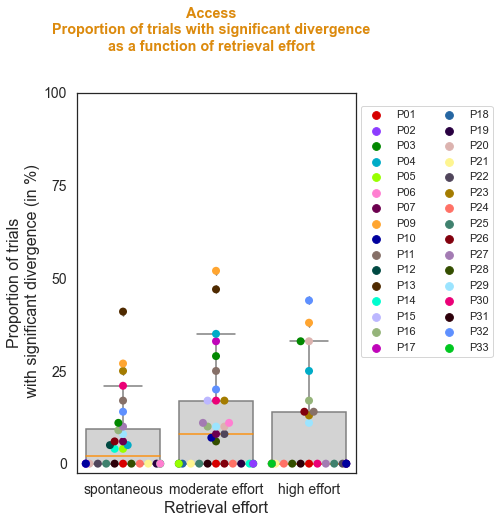

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


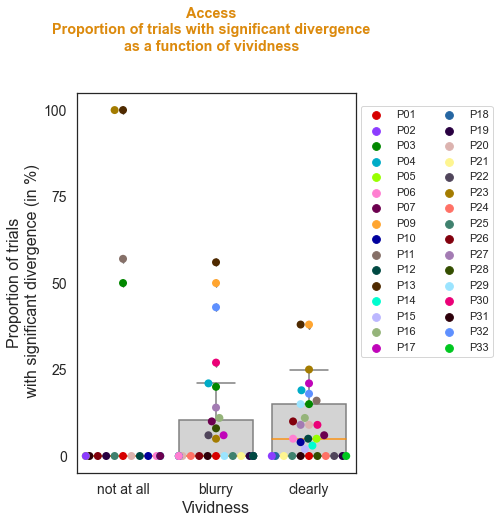

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 62.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


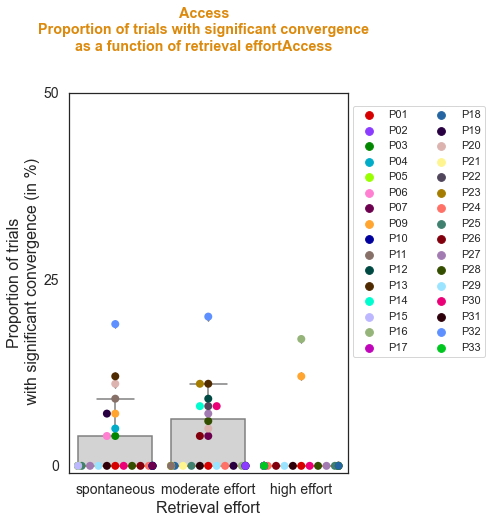

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


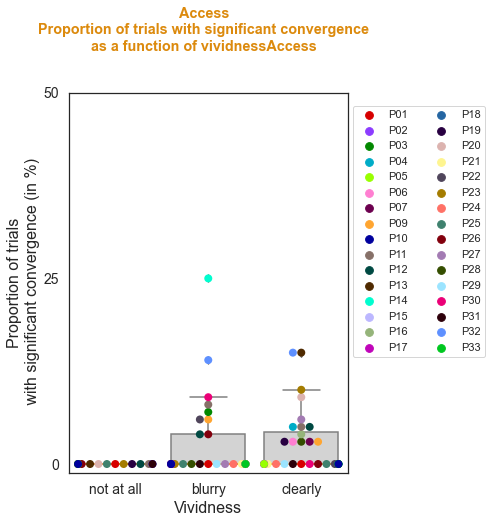

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 37.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


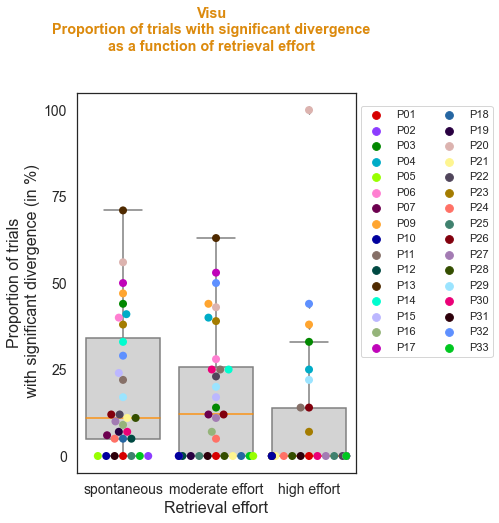

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


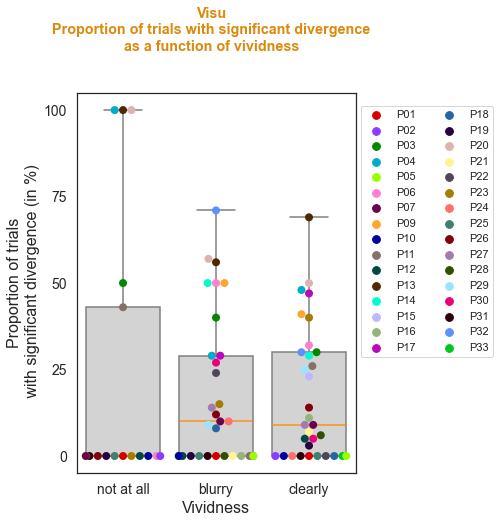

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 62.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


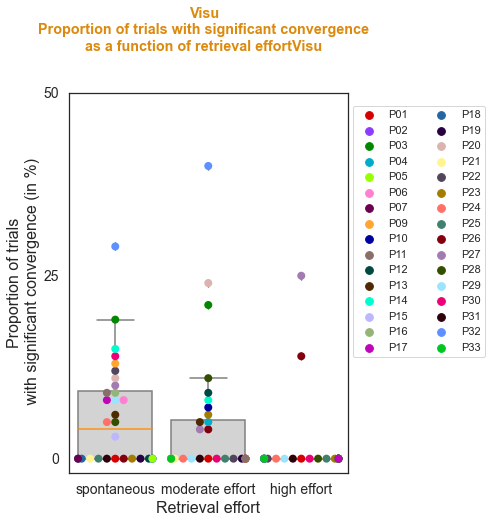

C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 38.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\anais\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


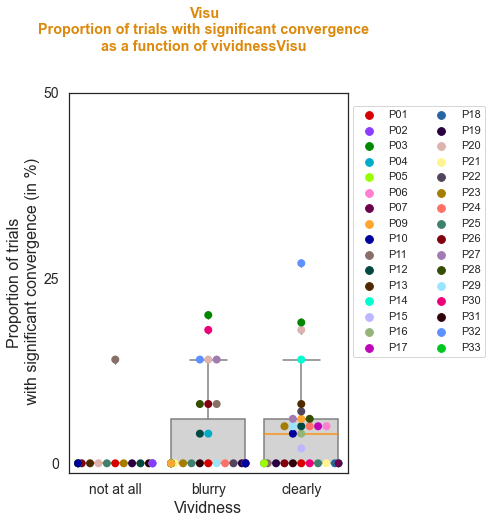

In [22]:
def plot_interaction_vergence_with_effort_and_vivid(df, title):
# supplementary figures
    # SIG DIVERGENCE

    L_title=[title +"\nProportion of trials with significant divergence\nas a function of retrieval effort",\
             title+"\nProportion of trials with significant divergence\nas a function of vividness"]
    for var_cat in range(len(L_var)) :
        var=L_var[var_cat]
        group=df.groupby(['Sujet',var])
        proportion=(group['sig_vergence'].value_counts(normalize=True).round(2))*100
        data=[]
        for i in idd_participant:
            
            prop_sujet=proportion[idd_participant[i]]
            for n in range(len(L_ticks[var_cat])):
                n=n+1
                if n in prop_sujet.index :   #s'assure qu'il y a la catégo demandée                  
                    percent=prop_sujet[n]
                    pp=percent.to_dict()
                    if 1 in pp: # because 1 is divergence
                        prop=pp[1]
                    else:
                        prop=0                    
                    data.append([idd_participant[i],n,prop])
        ddf=pd.DataFrame(data,columns=['sujet',var,'prop_VD'])
        if var == 'effort ':
            ddf.to_csv(wd_output_file  + '/div_' + title + "_effort.csv")
        if var == 'clarte':
            ddf.to_csv(wd_output_file  + '/div_' + title + "_clarte.csv")
        plt.figure(figsize=(5, 7))
        sns.set_theme(style="white")
        sns.boxplot(x=var,y='prop_VD',data=ddf,color='lightgrey',medianprops=dict(color="darkorange", alpha=0.9))
        # sns.set_theme(style="white")
        #sns.violinplot(x=var,y='prop_VD',data=ddf,color='lightgrey',cut = 0, inner = 'quartiles', showextrema=False,showmedians=True,quantiles=[0.25,0.75])
        palette = sns.color_palette(cc.glasbey_bw, n_colors=32)
        sns.swarmplot(x=var, y='prop_VD', data=ddf, size=8,hue='sujet',palette=palette)
        plt.xticks(range(len(L_ticks[var_cat])), L_ticks[var_cat], fontsize = 14)
        plt.xlabel(L_label[var_cat],size=16)
        plt.yticks([0, 25, 50, 75, 100], fontsize=14)
        #plt.tick_params(labelsize=13)
        plt.ylabel(ylabel="Proportion of trials\n with significant divergence (in %)",size=16)
        plt.legend(bbox_to_anchor = (1, 0.98),loc = 'upper left', ncol = 2)
        plt.suptitle(L_title[var_cat],fontweight='bold',color='#dc8a0d',y=1.05)
        plt.savefig(wd_output + '/supplementary/'+title+ '_Divergence_here_'+var+'.png',bbox_inches = "tight")
        plt.show()
        
 
    # SIG CONVERGENCE

    L_title=[title+"\nProportion of trials with significant convergence\nas a function of retrieval effort",\
             title+"\nProportion of trials with significant convergence\nas a function of vividness"]
    for var_cat in range(len(L_var)) :
        var=L_var[var_cat]
        group=df.groupby(['Sujet',var])
        proportion=(group['sig_vergence'].value_counts(normalize=True).round(2))*100
        data=[]
        for i in idd_participant:
            
            prop_sujet=proportion[idd_participant[i]]
            for n in range(len(L_ticks[var_cat])):
                n=n+1
                if n in prop_sujet.index :   #s'assure qu'il y a la catégo demandée                  
                    percent=prop_sujet[n]
                    pp=percent.to_dict()
                    if 0 in pp: # because 0 is convergence
                        prop=pp[0]
                    else:
                        prop=0                    
                    data.append([idd_participant[i],n,prop])
        ddf=pd.DataFrame(data,columns=['sujet',var,'prop_VD'])
        if var == 'effort ':
            ddf.to_csv(wd_output_file  + '/conv_' + title + "_effort.csv")
        if var == 'clarte':
            ddf.to_csv(wd_output_file + '/conv_' + title + "_clarte.csv")
        plt.figure(figsize=(5, 7))
        sns.set_theme(style="white")
        sns.boxplot(x=var,y='prop_VD',data=ddf,color='lightgrey',medianprops=dict(color="darkorange", alpha=0.9))
        palette = sns.color_palette(cc.glasbey_bw, n_colors=32)
        sns.swarmplot(x=var, y='prop_VD', data=ddf, size=8,hue='sujet',palette=palette)
        plt.xticks(range(len(L_ticks[var_cat])), L_ticks[var_cat], fontsize = 14)
        plt.xlabel(L_label[var_cat],size=16)
        plt.yticks([0, 25, 50], fontsize=14)
        #plt.tick_params(labelsize=13)
        plt.ylabel(ylabel="Proportion of trials\n with significant convergence (in %)",size=16)
        plt.legend(bbox_to_anchor = (1, 0.98),loc = 'upper left', ncol=2)
        plt.suptitle(L_title[var_cat]+title,fontweight='bold',color='#dc8a0d',y=1.05)
        plt.savefig(wd_output + '/supplementary/'+title + '_Convergence_here_'+var+'.png',bbox_inches = "tight")
        plt.show()

        
plot_interaction_vergence_with_effort_and_vivid(combined_df_access, 'Access')
plot_interaction_vergence_with_effort_and_vivid(combined_df_visu, 'Visu')

## For statistics, add info about divergence or convergence in the main data and save the files

In [23]:
for i in range(len(combined_df_access)):
    if combined_df_access['sig_vergence'][i] == 1:
        combined_df_access['sig_vergence'][i] = "divergence"
    elif combined_df_access['sig_vergence'][i] == 0:
        combined_df_access['sig_vergence'][i] = "convergence"
    else:
        combined_df_access['sig_vergence'][i] = "none"

for i in range(len(combined_df_visu)):
    if combined_df_visu['sig_vergence'][i] == 1:
        combined_df_visu['sig_vergence'][i] = "divergence"
    elif combined_df_visu['sig_vergence'][i] == 0:
        combined_df_visu['sig_vergence'][i] = "convergence"
    else:
        combined_df_visu['sig_vergence'][i] = "none"

combined_df_access.to_csv(wd_output_file + "\\vergence_access.csv")
combined_df_visu.to_csv(wd_output_file + "\\vergence_visu.csv")

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C: